In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator
from datasets import MovieLensGenreCastUserData, RatioSplit, CrossValidation

import os
import time
import logging
from scipy.sparse import csr_matrix
from cmfrec import CMF
import numpy as np, pandas as pd, pickle

from utils import binarize, show_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
k = 50
lambda_ = 10
maxiter = 800

# Loading ml-1m with negative sampling

In [43]:
root = os.path.abspath("../../cmfrec/example")

ratings = pickle.load(open(os.path.join(root, "ratings.p"), "rb"))
item_sideinfo_pca = pickle.load(open(os.path.join(root, "item_sideinfo_pca.p"), "rb"))
user_side_info = pickle.load(open(os.path.join(root, "user_side_info.p"), "rb"))
movie_id_to_title = pickle.load(open(os.path.join(root, "movie_id_to_title.p"), "rb"))
print(ratings.shape, user_side_info.shape, item_sideinfo_pca.shape)

(1000209, 3) (6040, 39) (3102, 51)


In [4]:
data = MovieLensGenreCastUserData(size='100k')
data.load()
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [6]:
X, Y, Z, _ = data.Xs

In [7]:
X_split = RatioSplit(X, test_size=20000)
X_split

[I] RatioSplit, sampling positives
[I]   seed         : 1705414851
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1705414851


In [26]:
X_split.negative_sample(train_size=X_split.pos_train_size, test_size=X_split.pos_test_size, type='popularity')
X_split

[I] RatioSplit, sampling negatives
[I]   all_negatives: 1486126
[I]   n_negatives  : 100000
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1705414851


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [27]:
X_train, X_test = X_split.X_train, X_split.X_test

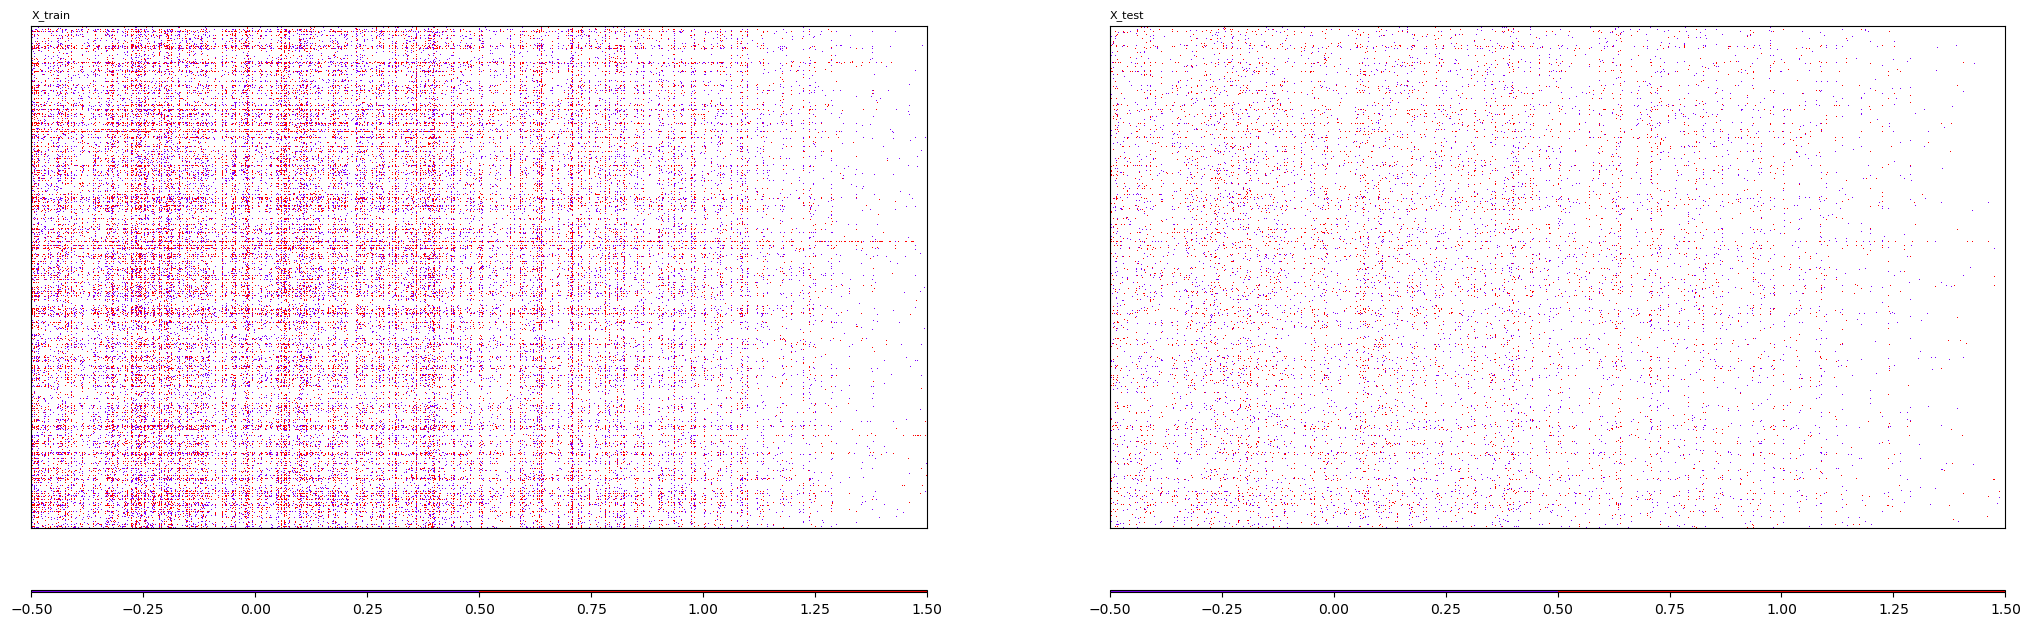

In [28]:
s = [(X_train, [0, 0], 'X_train'), (X_test, [0, 1], 'X_test')]
show_matrix(settings=s, colorbar=True, cmap='rainbow', discrete=True, center=True, keep_nan=True)

# cmf-1, means

In [29]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter)
model.fit(X_train)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_
display(miu)

0.5

In [31]:
def show_results(means=True):
    P = A @ B.T
    if means is True:
        for r in range(P.shape[0]):
            P[r, :] += a[r]
        for c in range(P.shape[1]):
            P[:, c] += b[c]
        P += miu

    rows, cols = X_train.tocoo().row, X_train.tocoo().col
    X_recover = np.empty(shape=X_train.shape)
    X_recover.fill(np.nan)
    for i in range(len(rows)):
        X_recover[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_recover = csr_matrix(X_recover)

    rows, cols = X_test.tocoo().row, X_test.tocoo().col
    X_predict = np.empty(shape=X_test.shape)
    X_predict.fill(np.nan)
    for i in range(len(rows)):
        X_predict[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_predict = csr_matrix(X_predict)

    rng = [200, 200]
    settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
                (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
                (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
                (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
                (P[:rng[0], :rng[1]], [0, 2], 'all predict')]
    show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

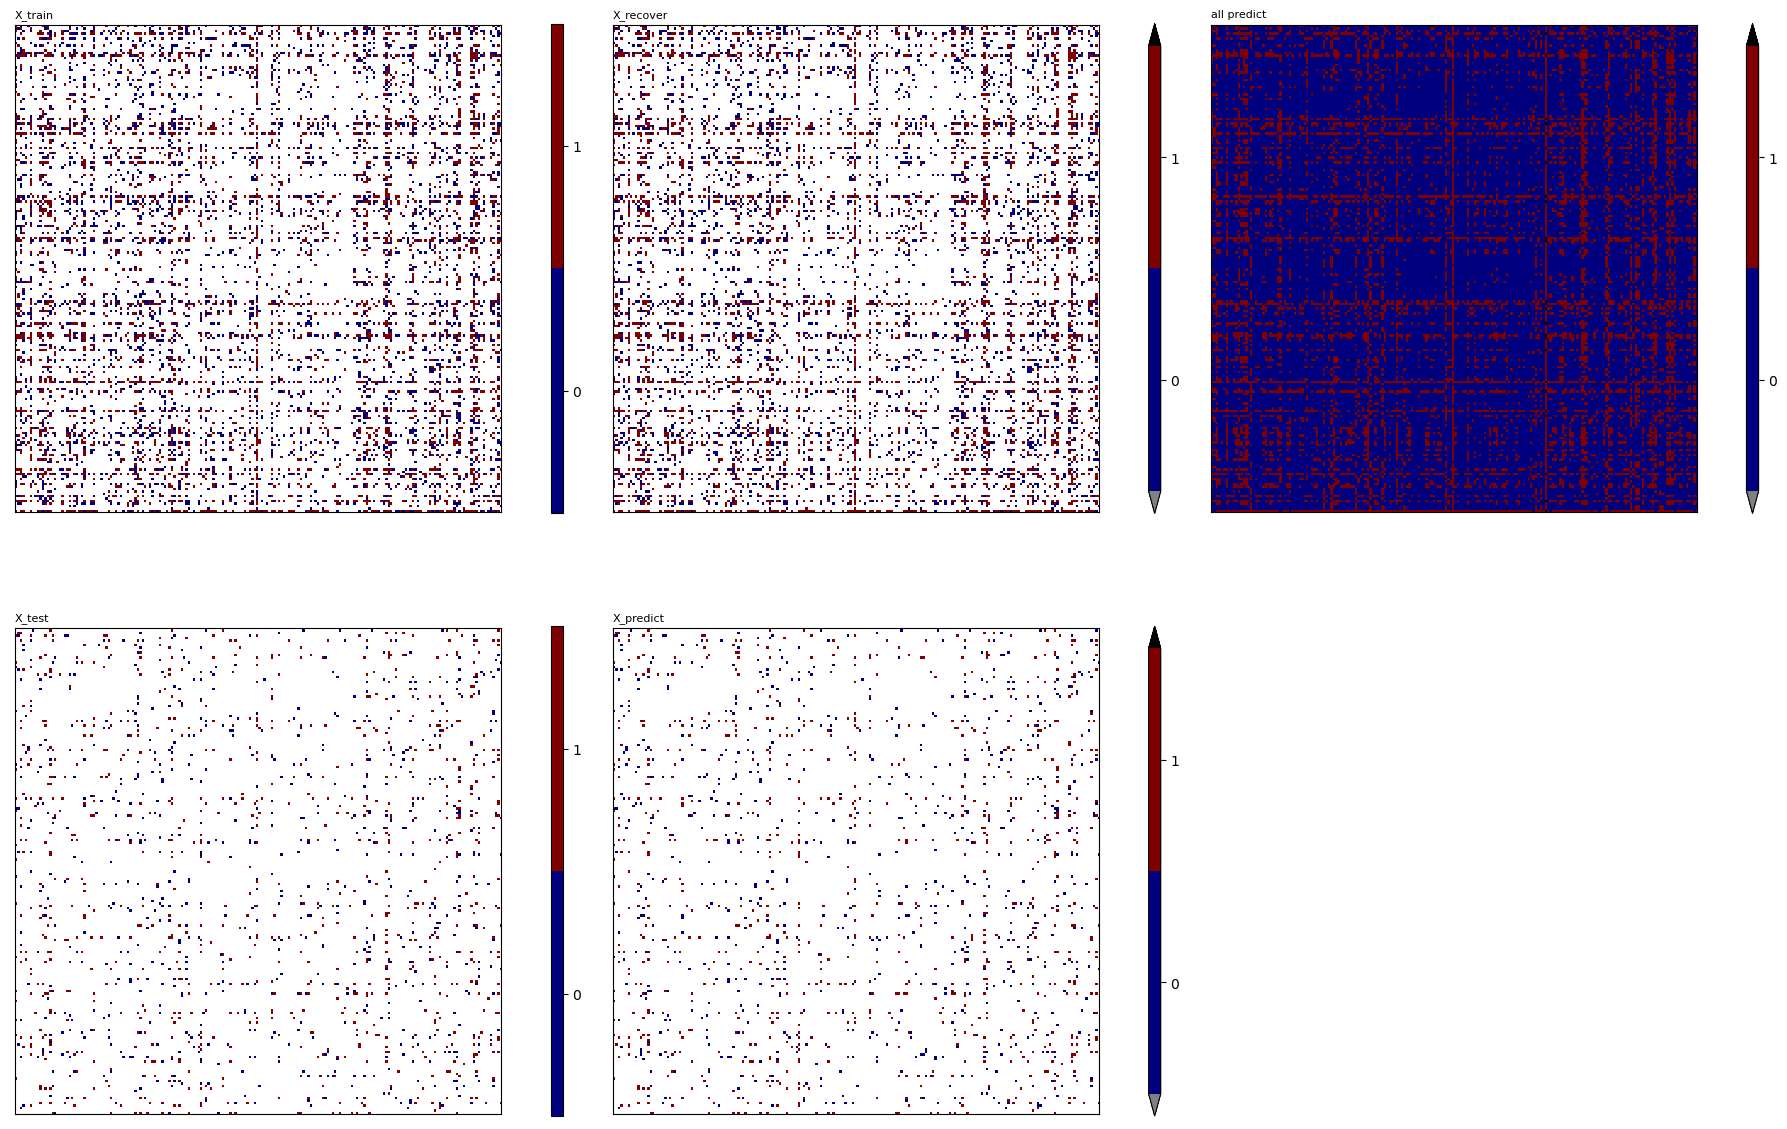

In [32]:
show_results(means=True)

# cmf-1

In [33]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False)
model.fit(X_train)

A, B = model.A_, model.B_
P = A @ B.T

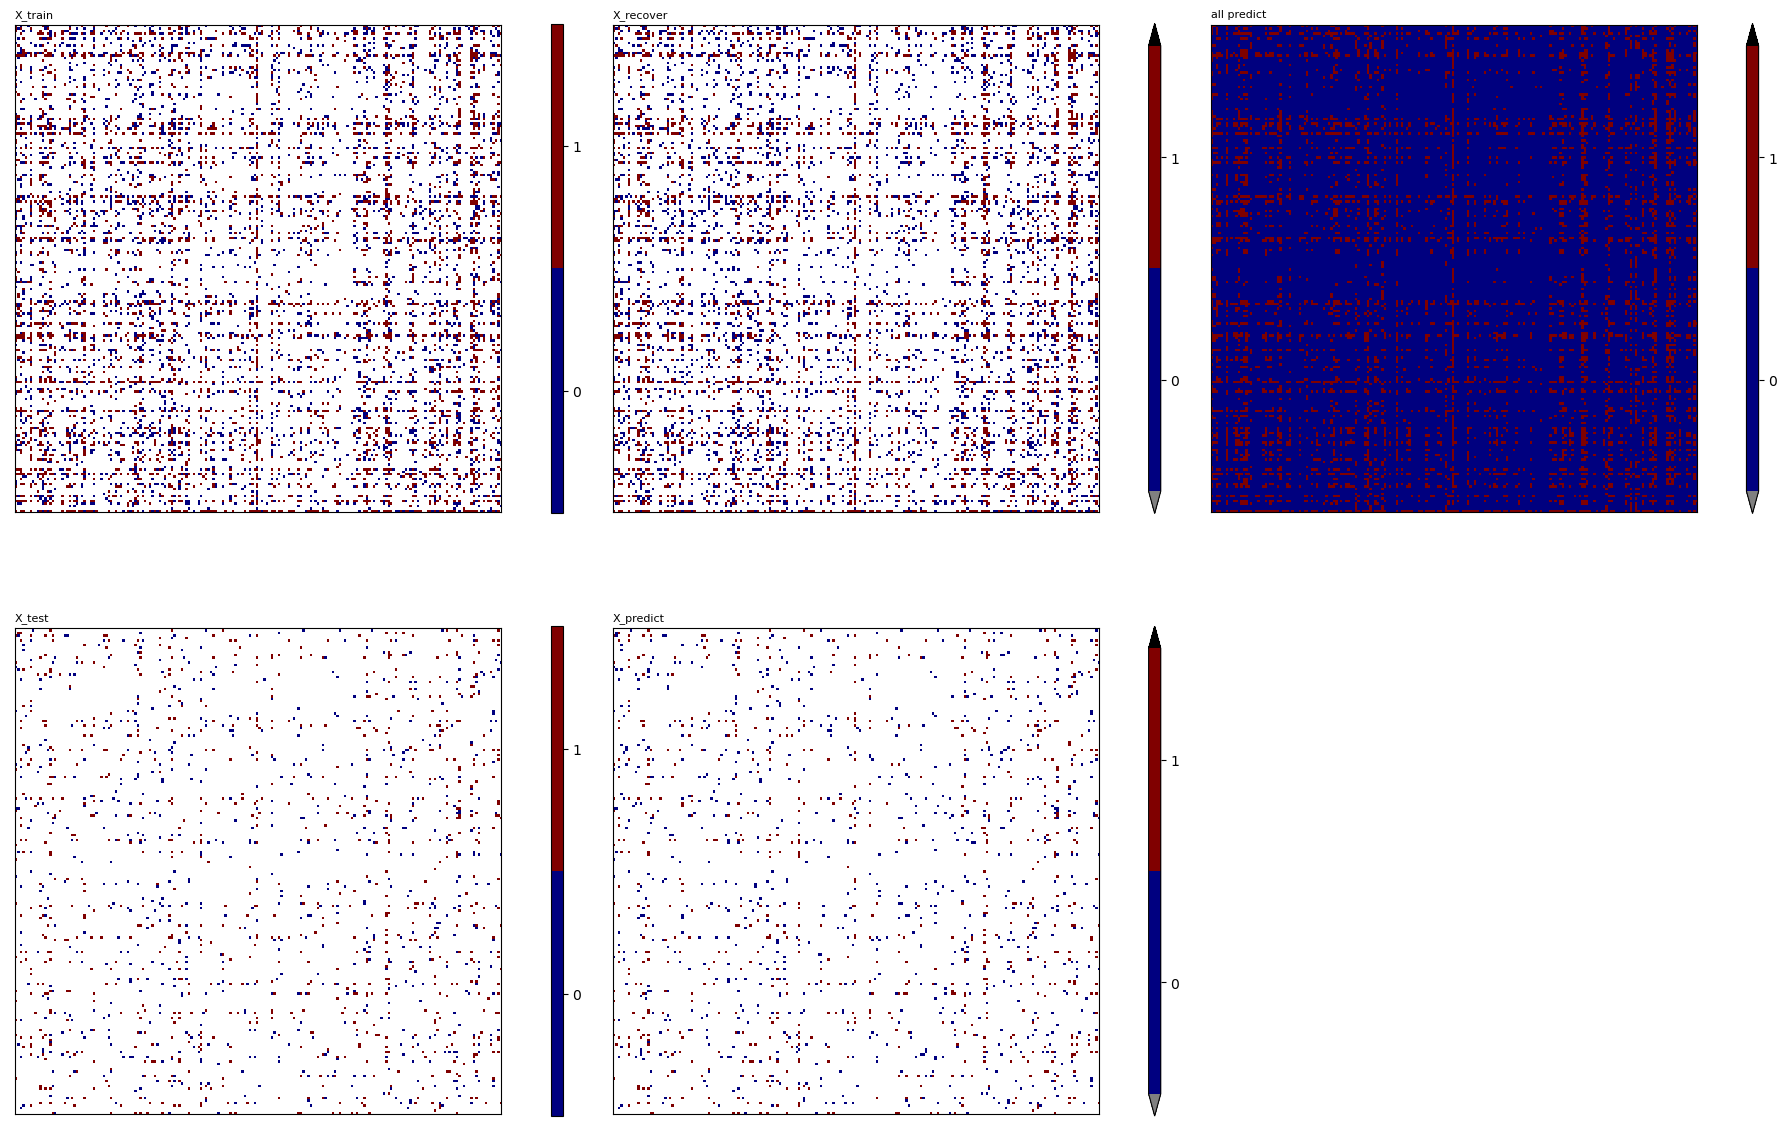

In [34]:
show_results(means=False)

# cmf-1, lbfgs, means

In [35]:
model = CMF(method="lbfgs", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter)
model.fit(X_train)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

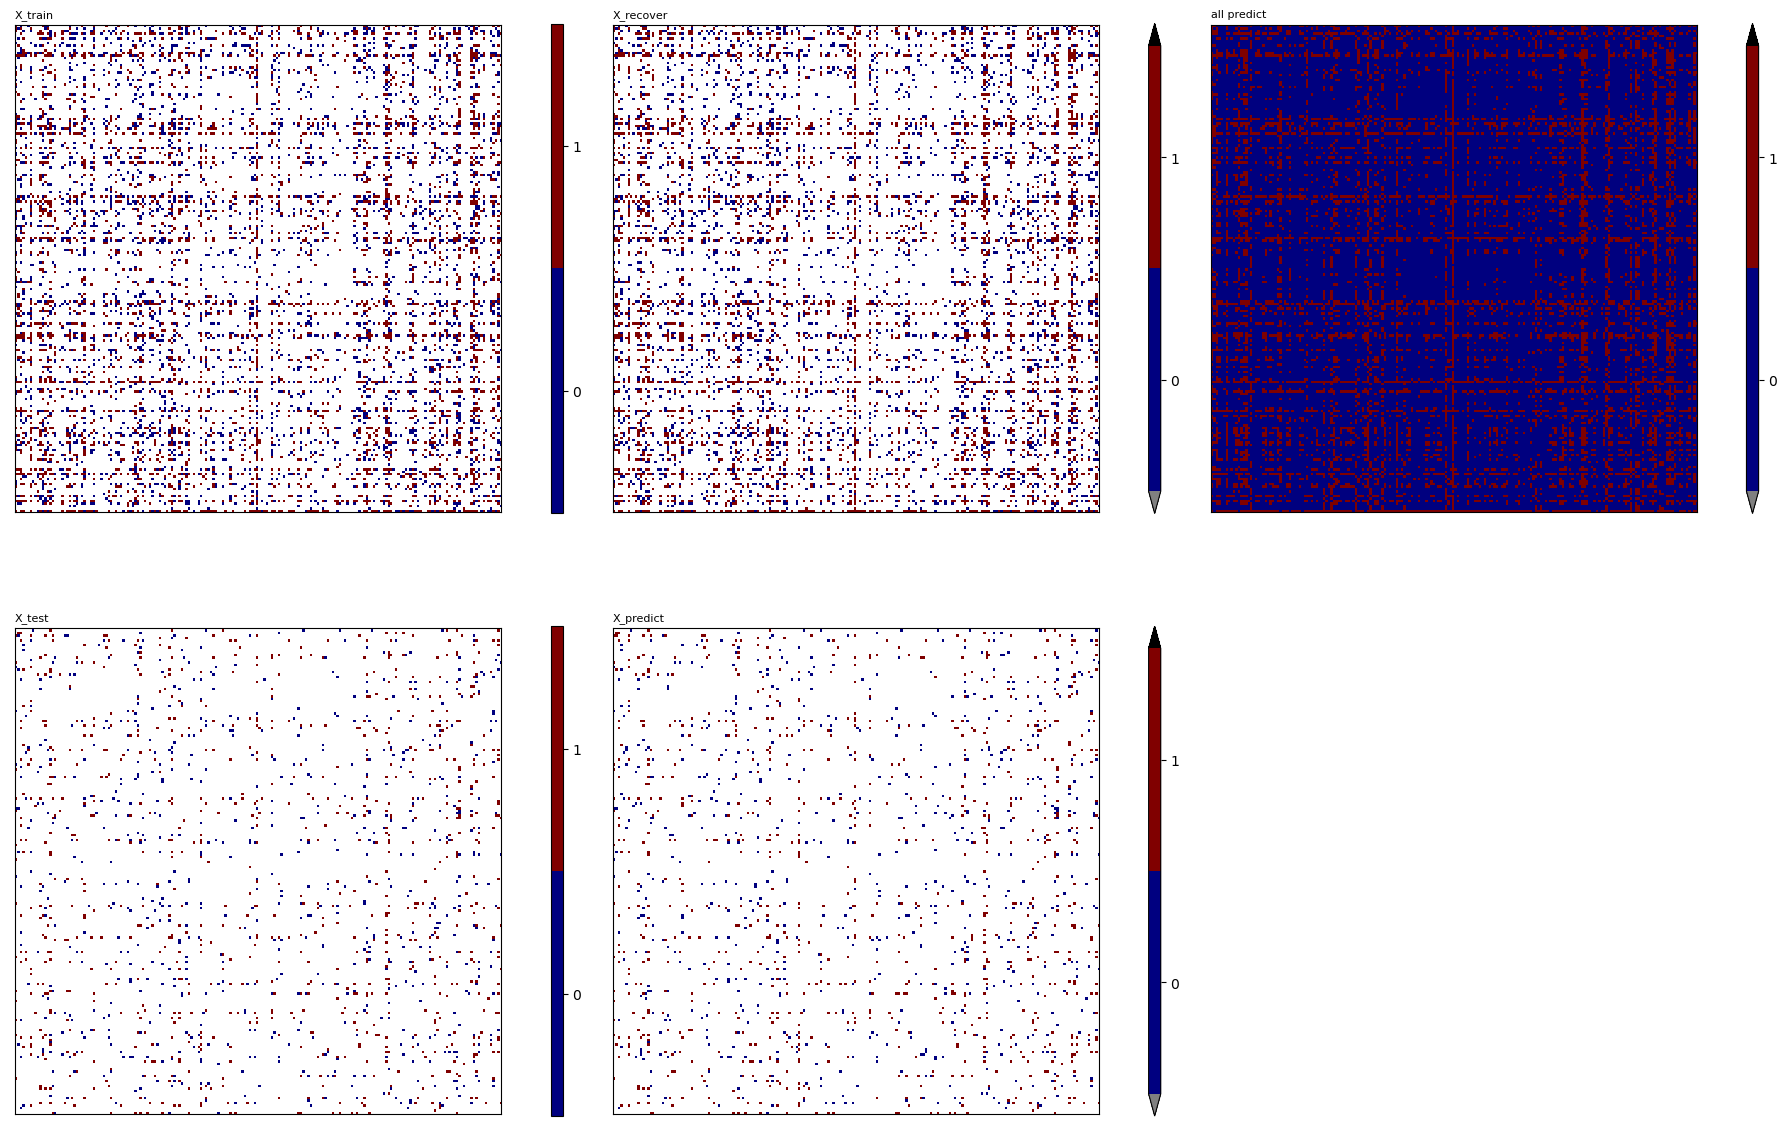

In [37]:
show_results(means=True)

# cmf-1, lbfgs

In [38]:
model = CMF(method="lbfgs", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False)
model.fit(X_train)

A, B = model.A_, model.B_

P = A @ B.T

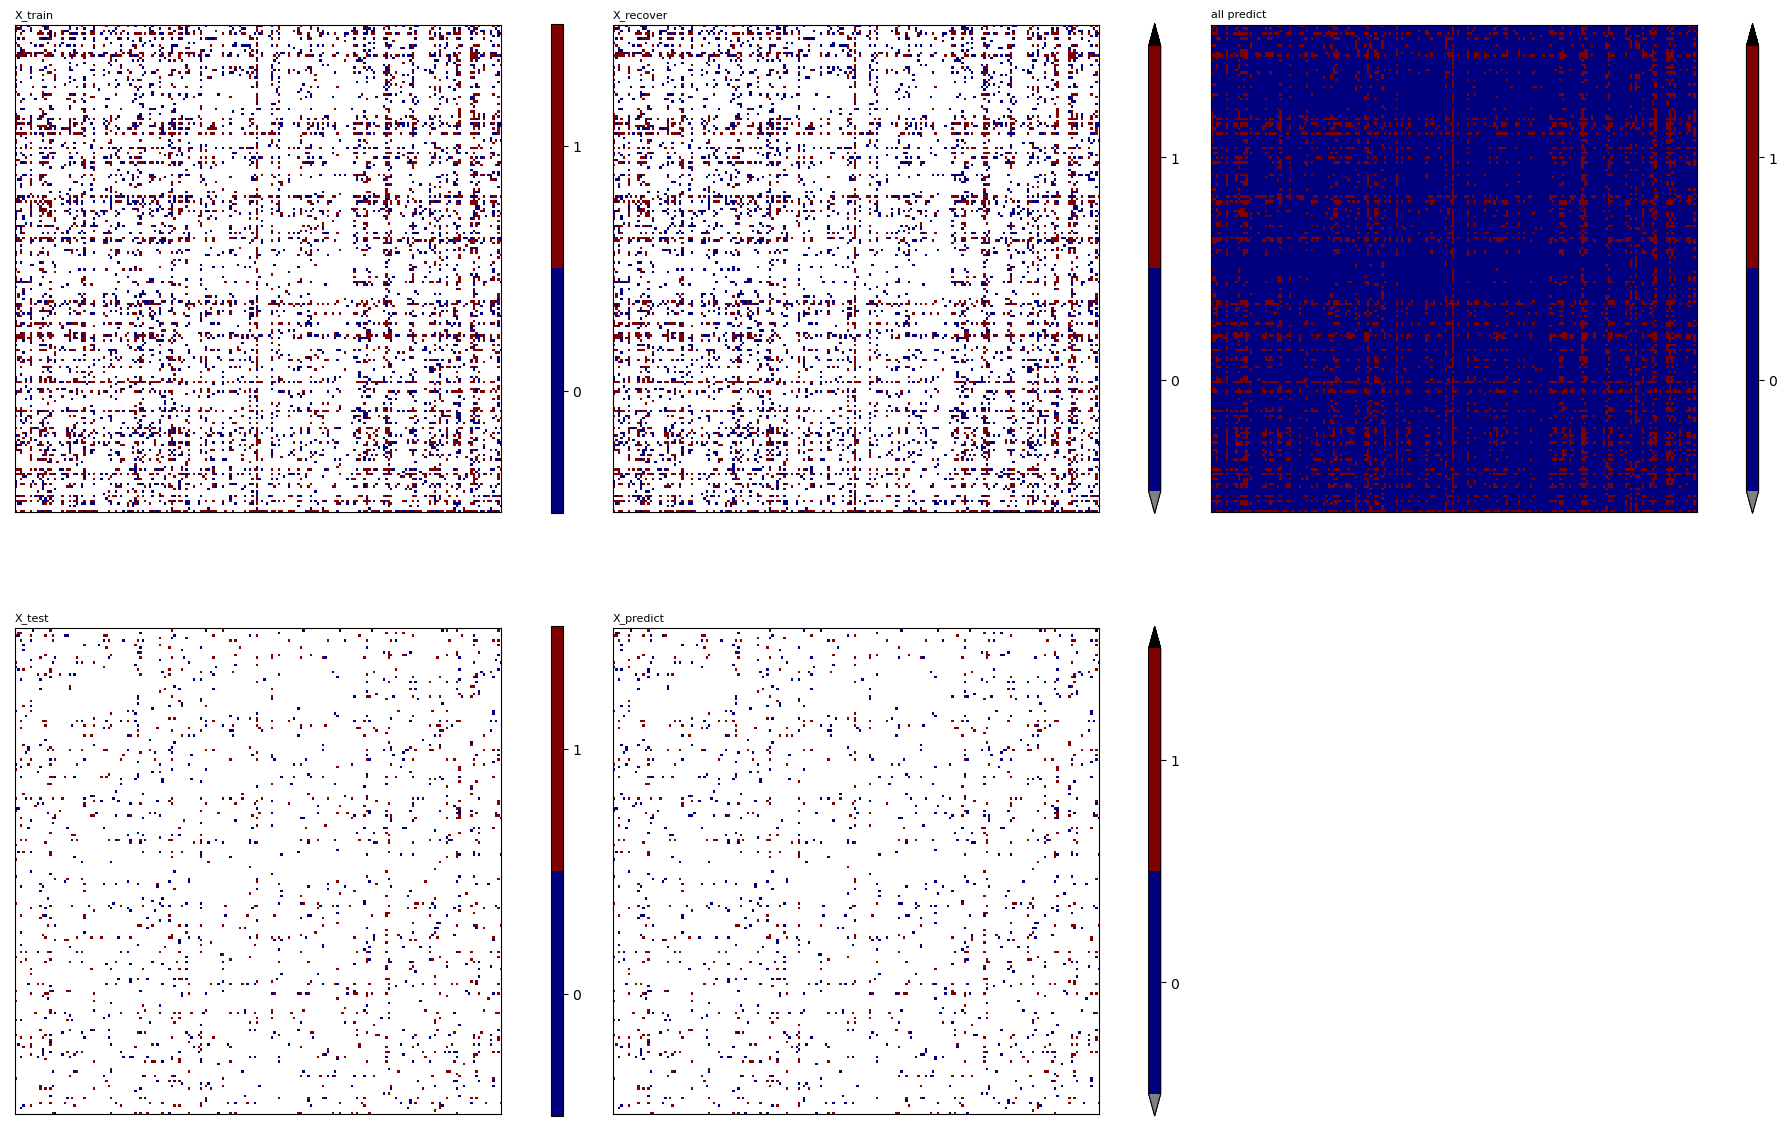

In [39]:
show_results(means=False)

# cmf-3, als, means

In [44]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

Collective matrix factorization model
(explicit-feedback variant)


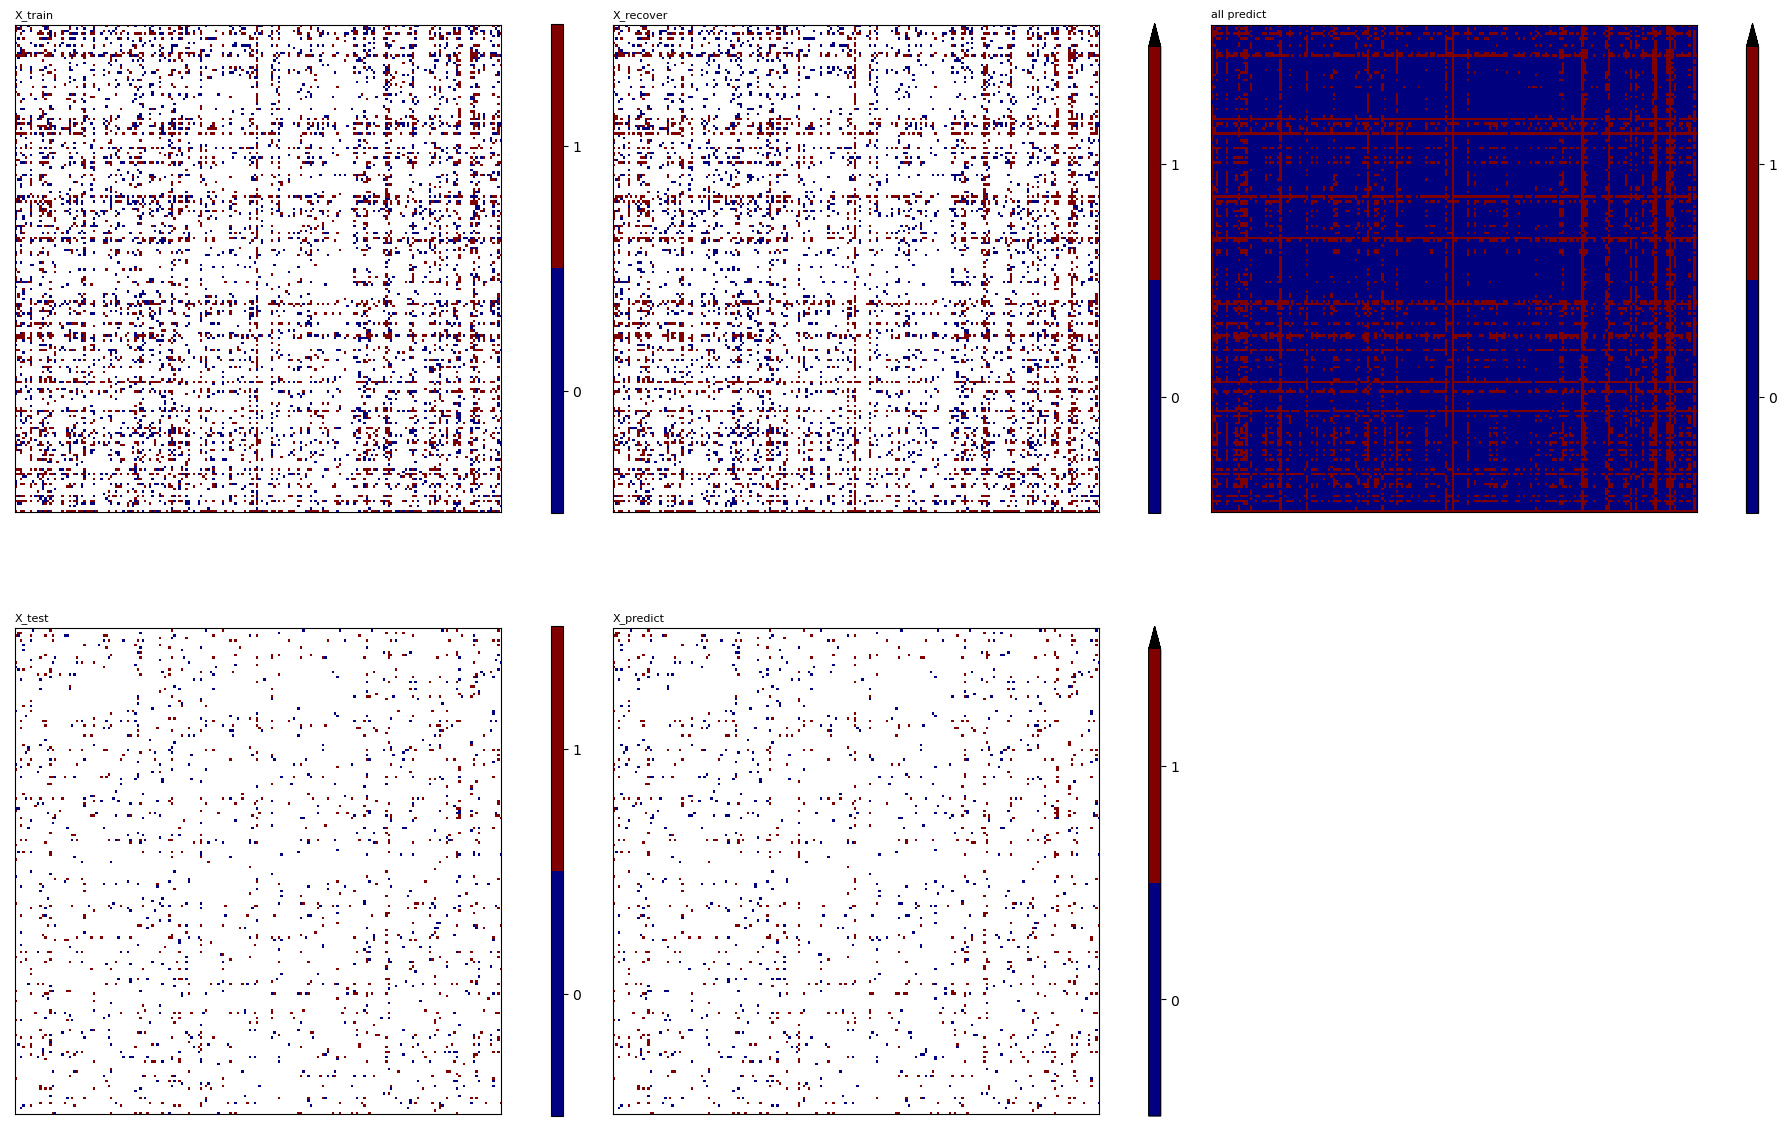

In [45]:
show_results(means=True)

# cmf-3, als

In [46]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False, user_bias=False, item_bias=False, center=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
P = A @ B.T

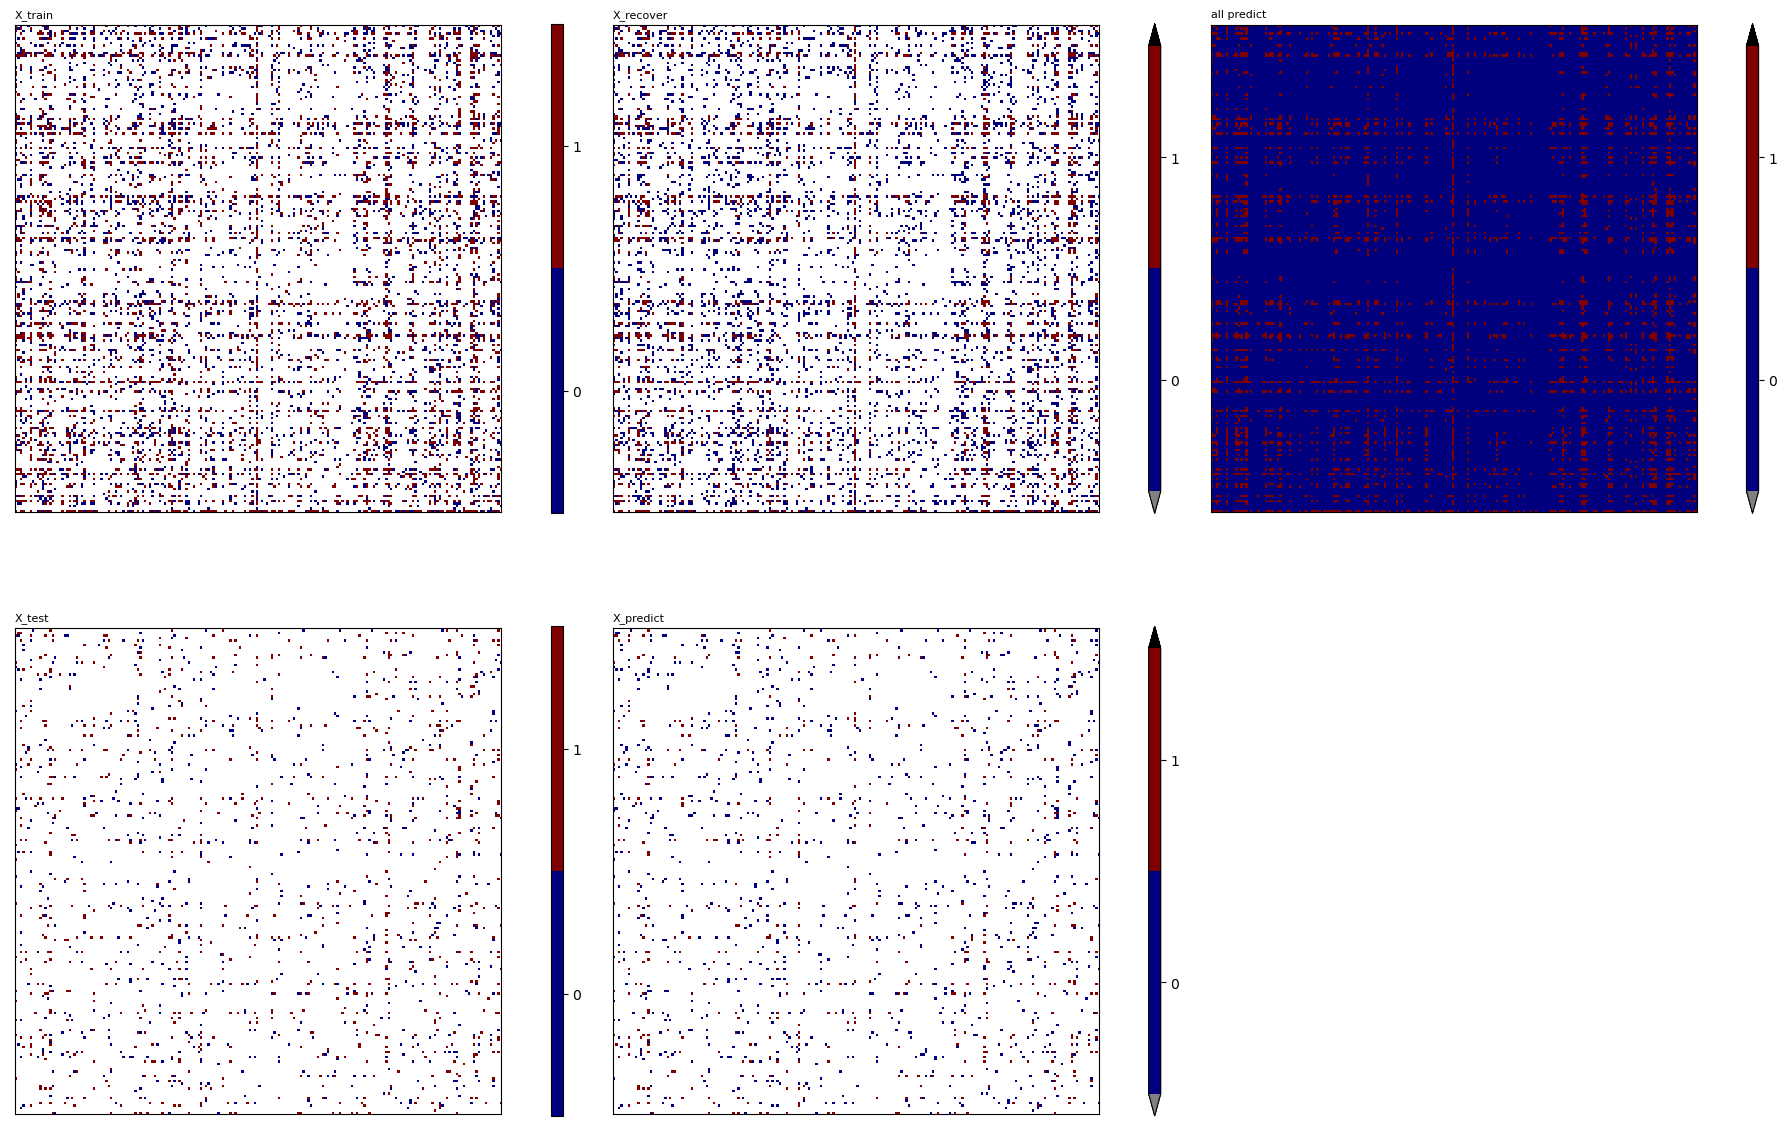

In [47]:
show_results(means=False)

# cmf-3, lbfgs, mean

In [48]:
# for the sigmoid transformations:
model = CMF(method="lbfgs", maxiter=maxiter, k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

Iteration 10   - f(x)= 9.37e+03 - ||g(x)||= 5.63     - ls= 1
Iteration 20   - f(x)= 9.33e+03 - ||g(x)||= 168      - ls= 2
Iteration 30   - f(x)= 9.04e+03 - ||g(x)||= 41.5     - ls= 1
Iteration 40   - f(x)= 9.02e+03 - ||g(x)||= 4.82     - ls= 1
Iteration 50   - f(x)= 9.02e+03 - ||g(x)||= 21.8     - ls= 1
Iteration 60   - f(x)= 9.02e+03 - ||g(x)||= 2.98     - ls= 1
Iteration 70   - f(x)= 9.02e+03 - ||g(x)||= 2.38     - ls= 1
Iteration 80   - f(x)= 9.02e+03 - ||g(x)||= 4.36     - ls= 1
Iteration 90   - f(x)= 9.02e+03 - ||g(x)||= 0.5      - ls= 1
Iteration 100  - f(x)= 9.02e+03 - ||g(x)||= 0.571    - ls= 1
Iteration 110  - f(x)= 9.02e+03 - ||g(x)||= 0.034    - ls= 1
Iteration 120  - f(x)= 9.02e+03 - ||g(x)||= 0.0245   - ls= 1
Iteration 130  - f(x)= 9.02e+03 - ||g(x)||= 0.0144   - ls= 1
Iteration 140  - f(x)= 9.02e+03 - ||g(x)||= 0.0161   - ls= 1
Iteration 150  - f(x)= 9.02e+03 - ||g(x)||= 0.00947  - ls= 1
Iteration 160  - f(x)= 9.02e+03 - ||g(x)||= 0.00955  - ls= 1
Iteration 170  - f(x)= 9

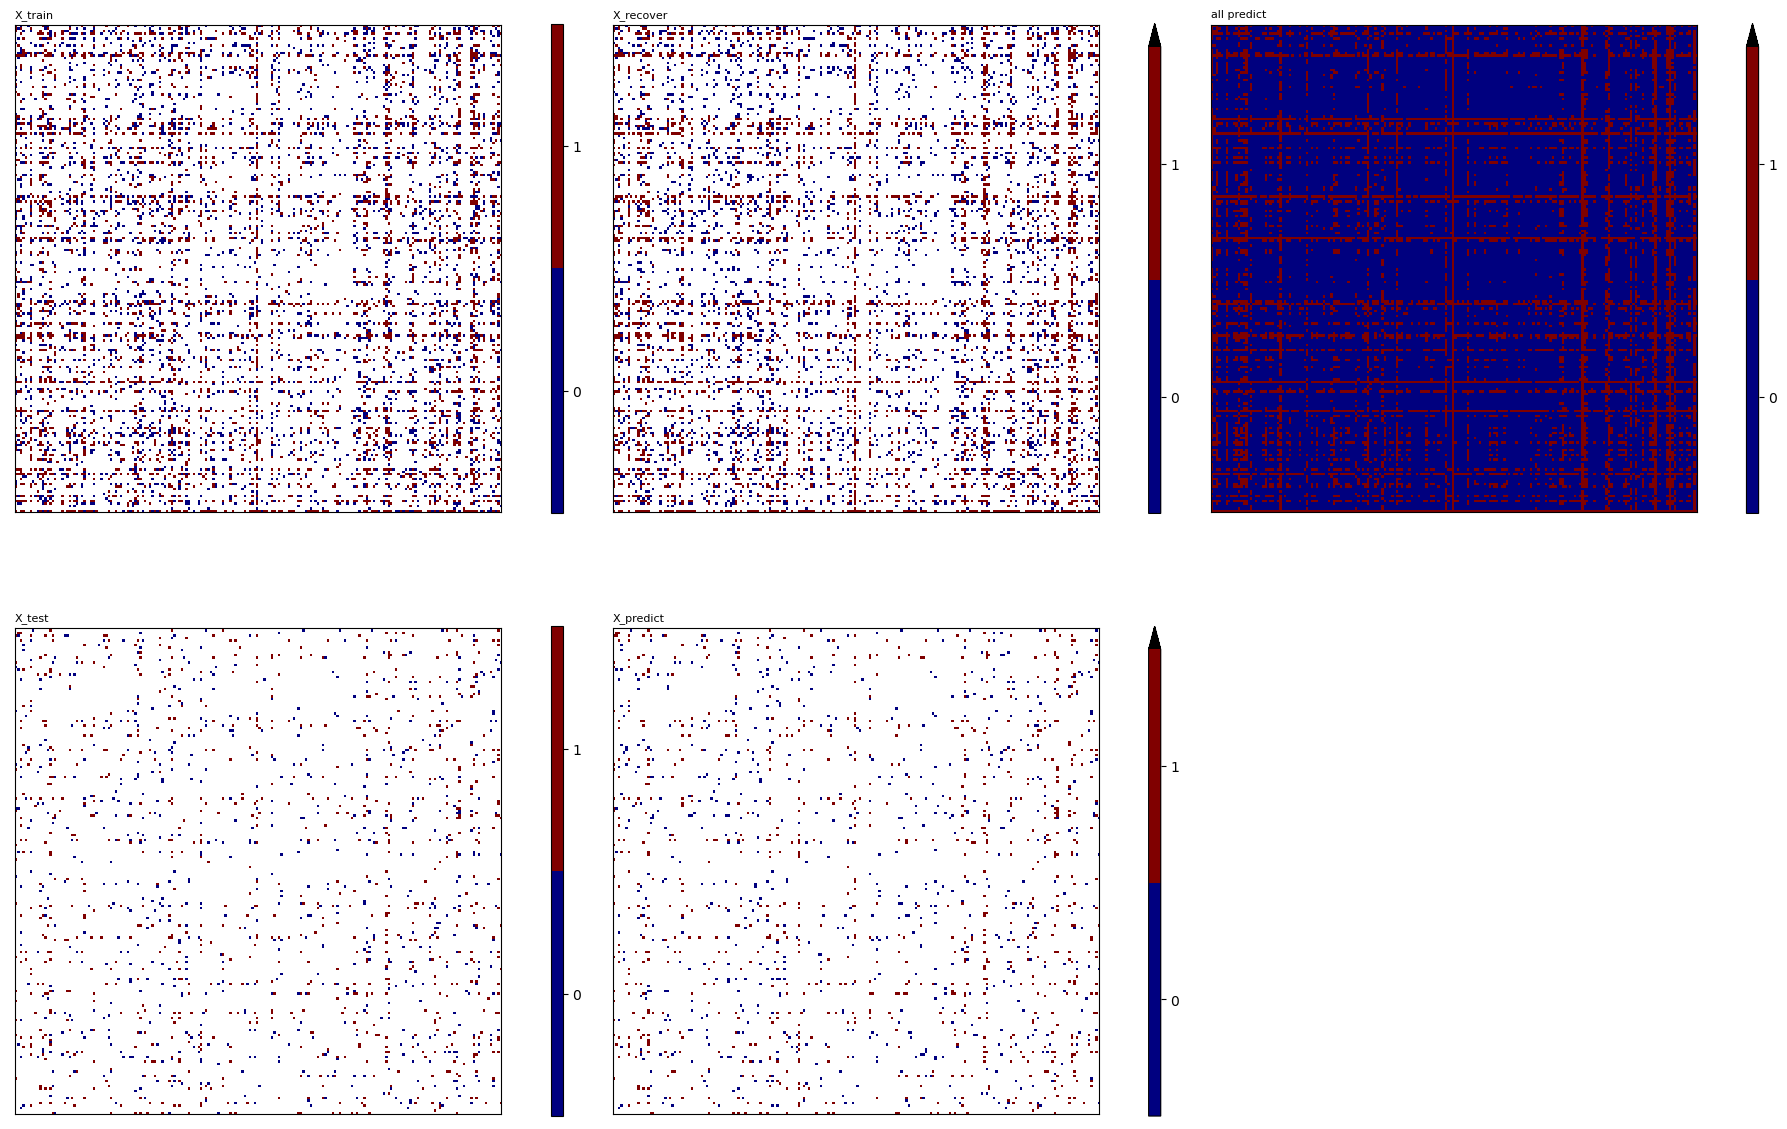

In [49]:
show_results(means=True)

# cmf-3, lbfgs

In [50]:
# for the sigmoid transformations:
model = CMF(method="lbfgs", maxiter=maxiter, k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, user_bias=False, item_bias=False, center=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
P = A @ B.T

Iteration 10   - f(x)= 1.24e+04 - ||g(x)||= 98.3     - ls= 1
Iteration 20   - f(x)= 1.23e+04 - ||g(x)||= 20.3     - ls= 1
Iteration 30   - f(x)= 1.23e+04 - ||g(x)||= 3.59     - ls= 1
Iteration 40   - f(x)= 1.23e+04 - ||g(x)||= 0.843    - ls= 1
Iteration 50   - f(x)= 1.23e+04 - ||g(x)||= 1.17     - ls= 5


Optimization terminated
	The line-search routine reaches the maximum number of evaluations.
	niter: 52, nfev:118


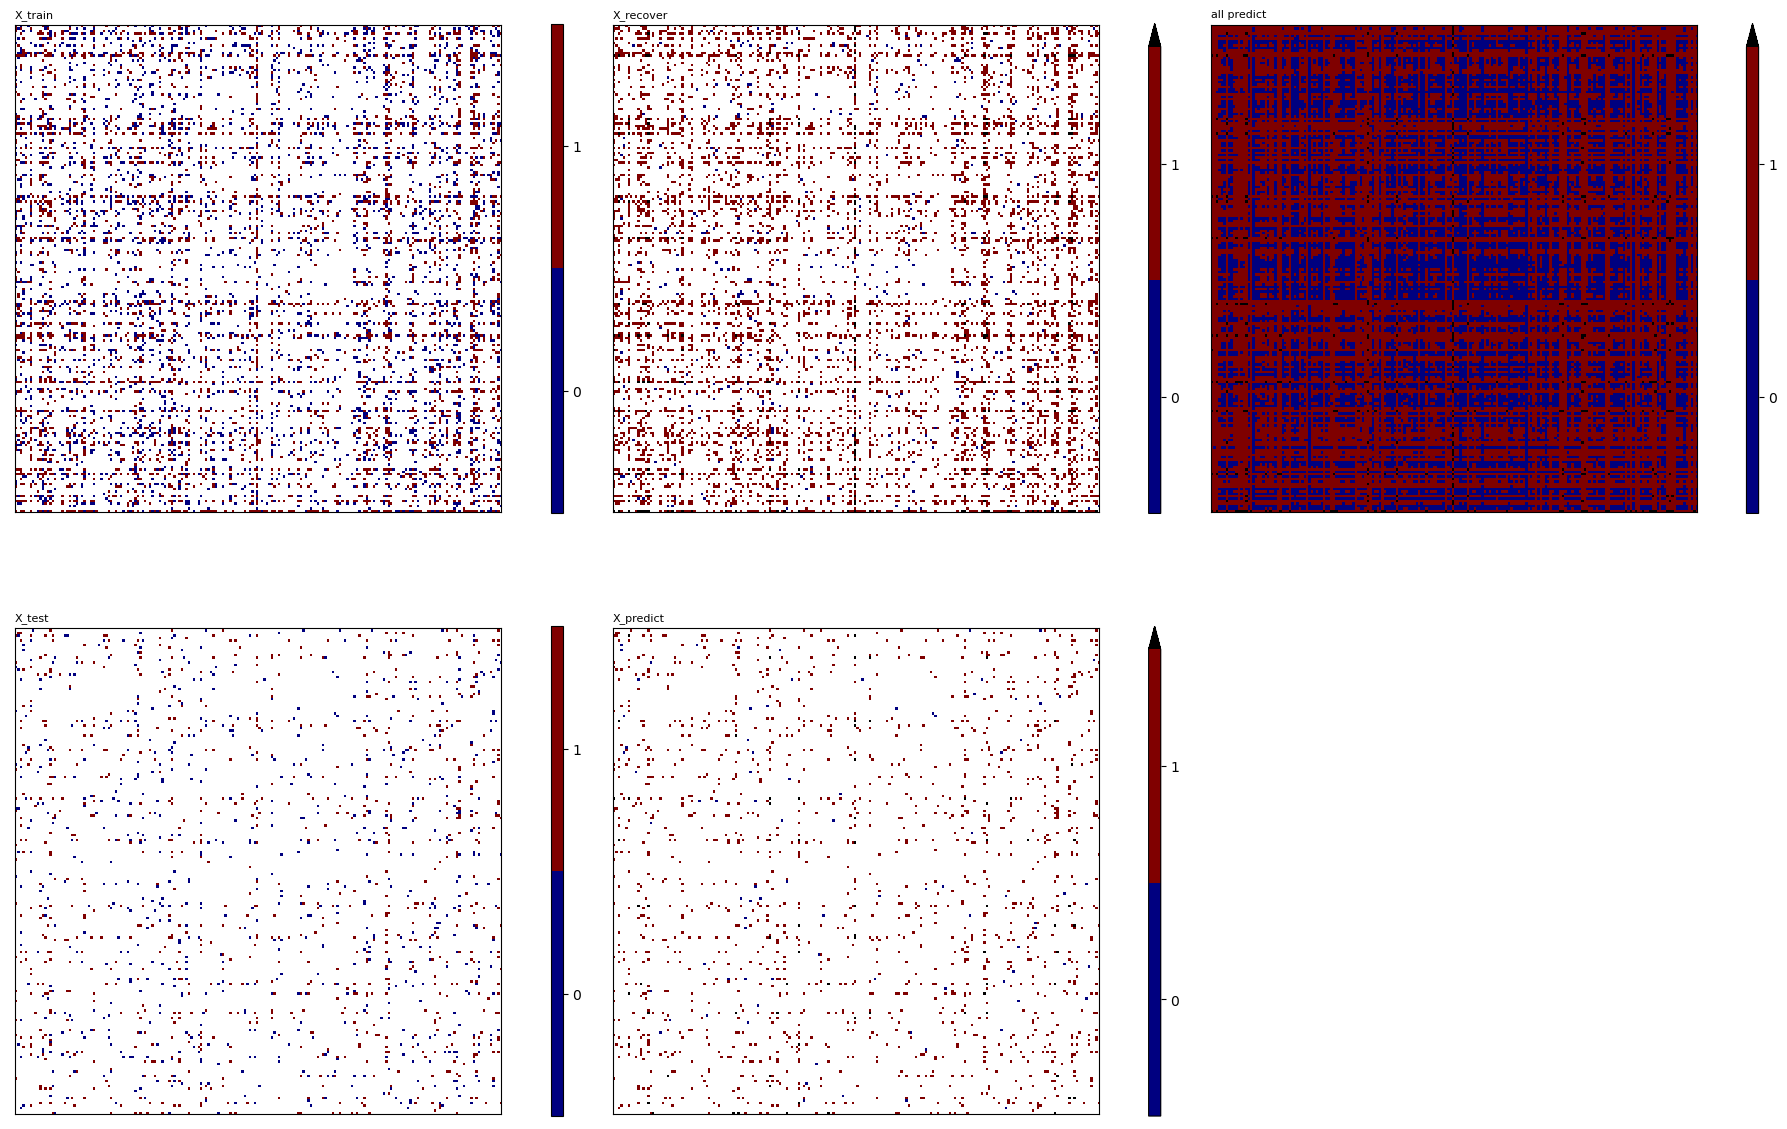

In [51]:
show_results(means=True)